In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# データの読み込み
data_g = pd.read_csv("./gps.us.csv", delimiter=',')
data_r = pd.read_csv("./rl.us.csv", delimiter=',')
# データの概要を表示
print("GPS Data Description:")
print(data_g.describe())
print("\nRL Data Description:")
print(data_r.describe())

GPS Data Description:
              Open         High          Low        Close        Volume  \
count  7640.000000  7640.000000  7640.000000  7640.000000  7.640000e+03   
mean     15.452494    15.681138    15.223233    15.458017  6.430596e+06   
std      10.826195    10.966428    10.678482    10.827518  4.849891e+06   
min       0.425460     0.459060     0.425460     0.442360  0.000000e+00   
25%       5.038575     5.124200     4.957300     5.046850  3.462360e+06   
50%      15.205000    15.401500    15.018500    15.217500  5.181247e+06   
75%      22.024500    22.433250    21.647750    22.059750  7.957253e+06   
max      43.622000    44.181000    42.389000    43.462000  1.167938e+08   

       OpenInt  
count   7640.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  

RL Data Description:
              Open         High          Low        Close        Volume  \
count  3201.000000  3201.000000  3201.000000  3201.0

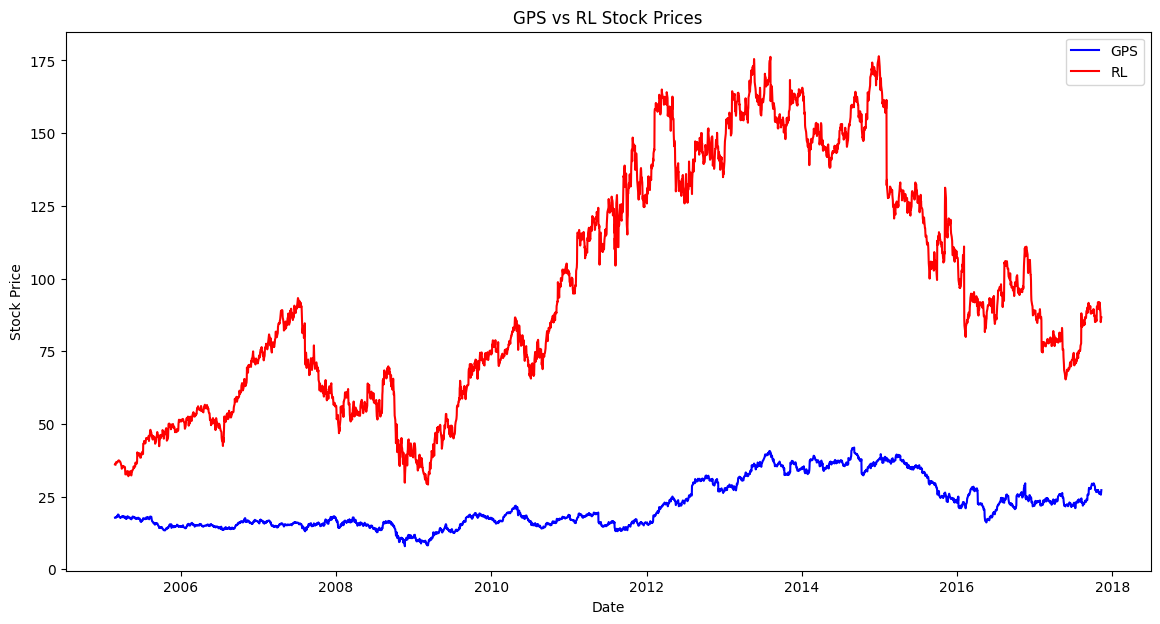

In [8]:
# Convert 'Date' column to datetime
data_g['Date'] = pd.to_datetime(data_g['Date'])
data_r['Date'] = pd.to_datetime(data_r['Date'])

# 両データセットの共通期間を取得
common_dates = pd.merge(data_g[['Date']], data_r[['Date']], on='Date', how='inner')
data_g = data_g[data_g['Date'].isin(common_dates['Date'])]
data_r = data_r[data_r['Date'].isin(common_dates['Date'])]

# データを日付でソート
data_g.sort_values('Date', inplace=True)
data_r.sort_values('Date', inplace=True)

# ラインチャートのプロット
plt.figure(figsize=(14, 7))
plt.plot(data_g['Date'], data_g['Close'], label='GPS', color='b')
plt.plot(data_r['Date'], data_r['Close'], label='RL', color='r')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('GPS vs RL Stock Prices')
plt.legend()
plt.show()

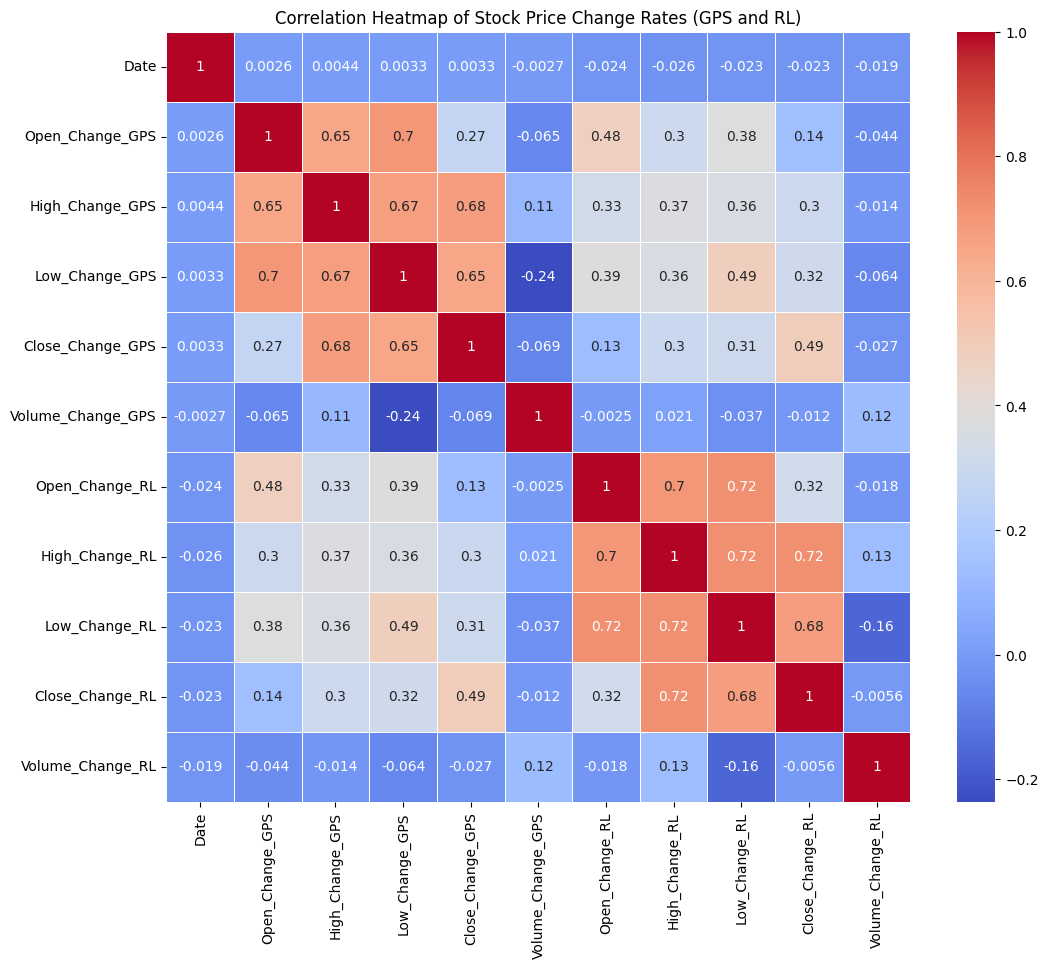

In [9]:
# 株価の変化率を計算
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data_g[f'{col}_Change'] = data_g[col].pct_change()
    data_r[f'{col}_Change'] = data_r[col].pct_change()

# 変化率のデータを結合
merged_data = pd.merge(
    data_g[['Date'] + [f'{col}_Change' for col in ['Open', 'High', 'Low', 'Close', 'Volume']]],
    data_r[['Date'] + [f'{col}_Change' for col in ['Open', 'High', 'Low', 'Close', 'Volume']]],
    on='Date',
    suffixes=('_GPS', '_RL')
)

# 欠損値を削除
merged_data.dropna(inplace=True)

# 相関係数の計算
correlation_matrix = merged_data.corr()

# ヒートマップのプロット
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Price Change Rates (GPS and RL)')
plt.show()

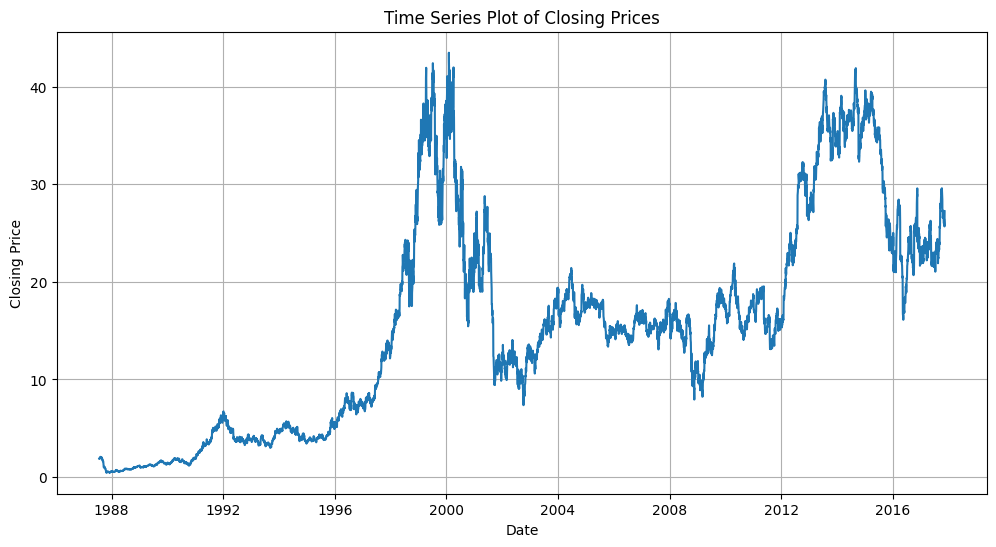

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64
Training MSE: 0.08839392823423389
Testing MSE: 0.5948485674696538


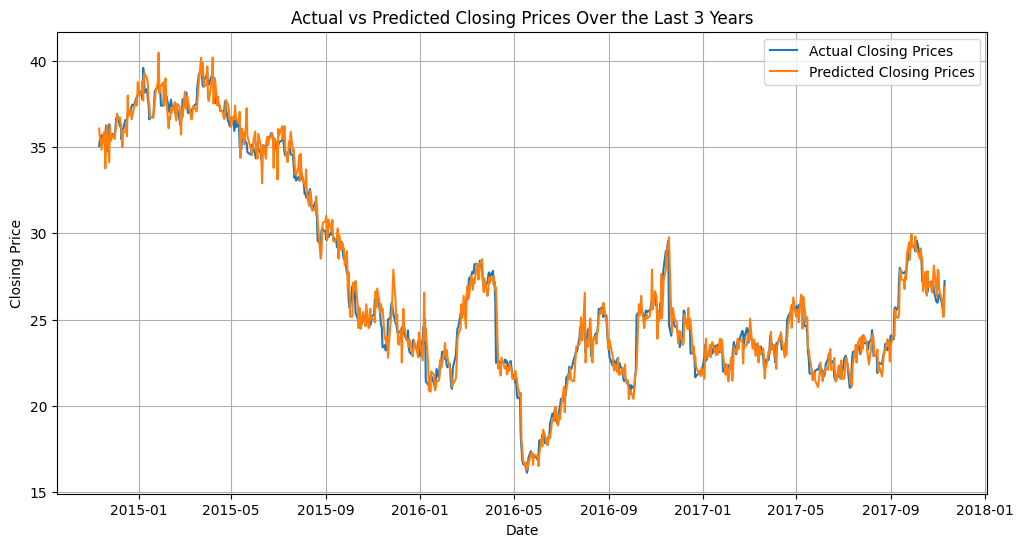

In [7]:
# データの読み込み
data_g = pd.read_csv("gps.us.csv", delimiter=',')

# 日付の形式を変換
data_g['Date'] = pd.to_datetime(data_g['Date'])

# データを日付でソート
data_g.sort_values(by='Date', inplace=True)

# 株価の時系列プロット
plt.figure(figsize=(12, 6))
plt.plot(data_g['Date'], data_g['Close'], label='Closing Price')
plt.title('Time Series Plot of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# 株価の散布図プロット
fig = px.scatter(data_g, x='Date', y='Close', title='Scatter Plot of Closing Prices')
fig.show()

# 欠損値の確認
print(data_g.isnull().sum())

# 欠損値の削除
data_g.dropna(inplace=True)

# 1日前の終値を特徴量として作成
data_g['Prev_Close'] = data_g['Close'].shift(1)
data_g.dropna(inplace=True)

# 特徴量とターゲットの設定
X = data_g[['Prev_Close']]
y = data_g['Close']

# 訓練データとテストデータに分割
train_end_date = data_g['Date'].max() - pd.DateOffset(years=3)
test_start_date = train_end_date + pd.DateOffset(days=1)

X_train = X[data_g['Date'] <= train_end_date]
y_train = y[data_g['Date'] <= train_end_date]
X_test = X[data_g['Date'] >= test_start_date]
y_test = y[data_g['Date'] >= test_start_date]

# ランダムフォレストモデルの訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# モデルの評価
train_mse = mean_squared_error(y_train, model.predict(X_train))
test_mse = mean_squared_error(y_test, model.predict(X_test))
print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")

# 将来の株価を予測
predicted_prices = model.predict(X_test)

# 実際の株価と予測株価のプロット
plt.figure(figsize=(12, 6))
plt.plot(data_g['Date'][data_g['Date'] >= test_start_date], y_test, label='Actual Closing Prices')
plt.plot(data_g['Date'][data_g['Date'] >= test_start_date], predicted_prices, label='Predicted Closing Prices')
plt.title('Actual vs Predicted Closing Prices Over the Last 3 Years')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.show()

Training MSE: 8.48098652083928
Testing MSE: 66.95834245110129


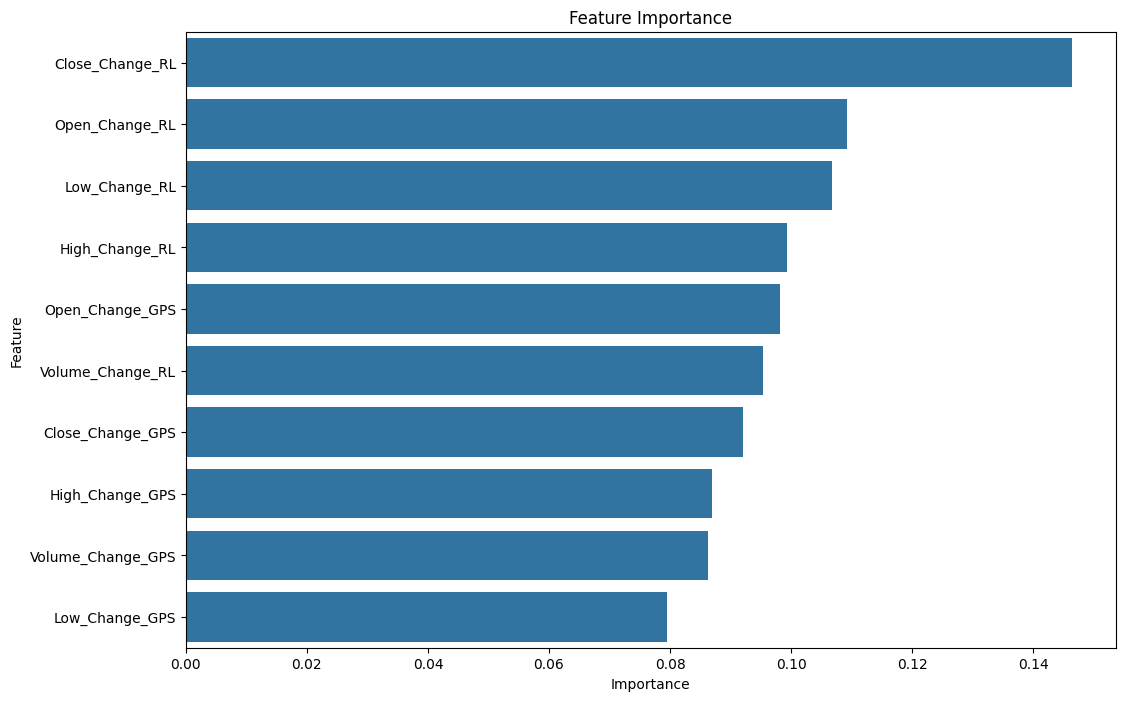

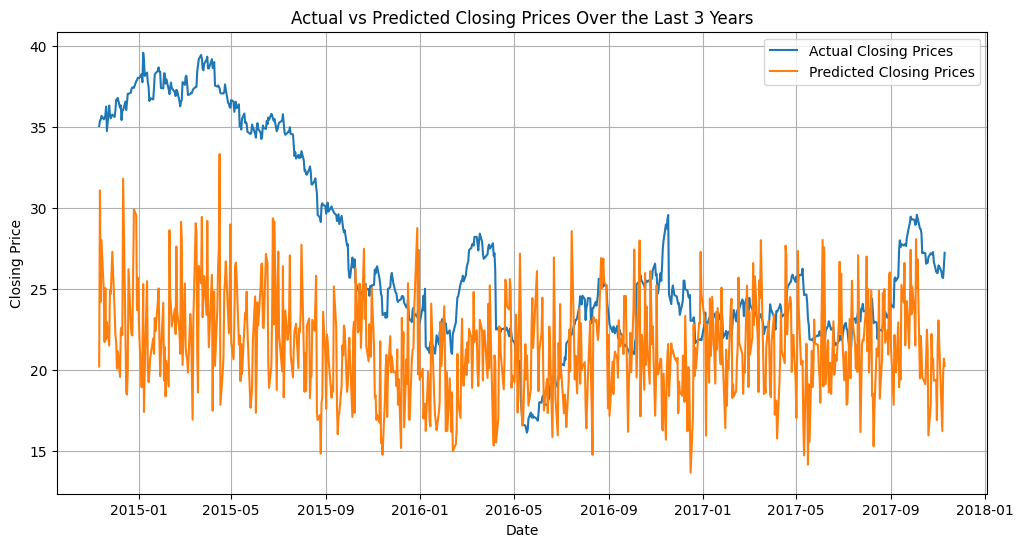

In [14]:
# 両データセットの共通期間を取得
common_dates = pd.merge(data_g[['Date']], data_r[['Date']], on='Date', how='inner')
data_g = data_g[data_g['Date'].isin(common_dates['Date'])]
data_r = data_r[data_r['Date'].isin(common_dates['Date'])]

# データを日付でソート
data_g.sort_values('Date', inplace=True)
data_r.sort_values('Date', inplace=True)

# 株価の変化率を計算
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data_g[f'{col}_Change'] = data_g[col].pct_change()
    data_r[f'{col}_Change'] = data_r[col].pct_change()

# 変化率のデータを結合
merged_data = pd.merge(
    data_g[['Date'] + [f'{col}_Change' for col in ['Open', 'High', 'Low', 'Close', 'Volume']]],
    data_r[['Date'] + [f'{col}_Change' for col in ['Open', 'High', 'Low', 'Close', 'Volume']]],
    on='Date',
    suffixes=('_GPS', '_RL')
)

# 欠損値と無限大を削除
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(inplace=True)

# Close_GPS列を作成
merged_data = merged_data.merge(data_g[['Date', 'Close']], on='Date')
merged_data.rename(columns={'Close': 'Close_GPS'}, inplace=True)

# 特徴量とターゲットの設定
features = [col for col in merged_data.columns if col not in ['Date', 'Close_GPS', 'Close_RL']]
target = 'Close_GPS'

X = merged_data[features]
y = merged_data[target]

# 訓練データとテストデータに分割
train_end_date = merged_data['Date'].max() - pd.DateOffset(years=3)
test_start_date = train_end_date + pd.DateOffset(days=1)

X_train = X[merged_data['Date'] <= train_end_date]
y_train = y[merged_data['Date'] <= train_end_date]
X_test = X[merged_data['Date'] >= test_start_date]
y_test = y[merged_data['Date'] >= test_start_date]

# ランダムフォレストモデルの訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# モデルの評価
train_mse = mean_squared_error(y_train, model.predict(X_train))
test_mse = mean_squared_error(y_test, model.predict(X_test))
print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")

# 特徴量の重要度を抽出
feature_importances = model.feature_importances_

# 特徴量の重要度をデータフレームに変換
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 特徴量の重要度をプロット
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 予測
predicted_prices = model.predict(X_test)

# 実際の株価と予測株価のプロット
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'][merged_data['Date'] >= test_start_date], y_test, label='Actual Closing Prices')
plt.plot(merged_data['Date'][merged_data['Date'] >= test_start_date], predicted_prices, label='Predicted Closing Prices')
plt.title('Actual vs Predicted Closing Prices Over the Last 3 Years')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.show()

Training MSE: 0.08839392823423389
Testing MSE: 0.5948485674696538


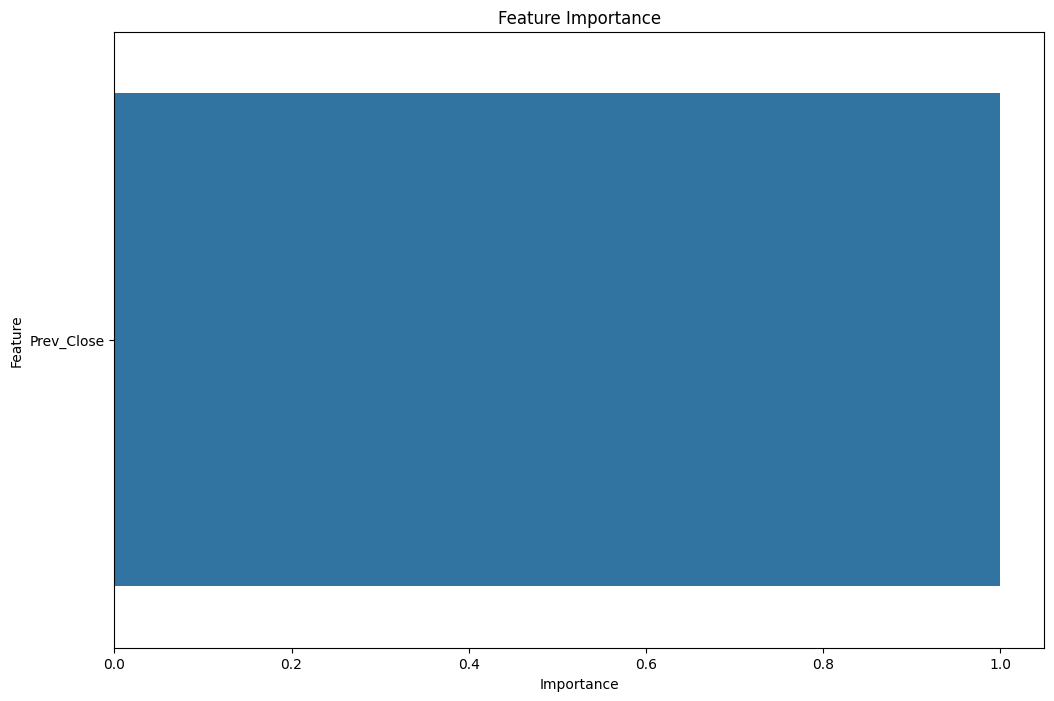

In [10]:
# ランダムフォレストモデルの訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# モデルの評価
train_mse = mean_squared_error(y_train, model.predict(X_train))
test_mse = mean_squared_error(y_test, model.predict(X_test))
print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")

# 特徴量の重要度を抽出
feature_importances = model.feature_importances_

# 特徴量の重要度をデータフレームに変換
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 特徴量の重要度をプロット
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
